# 1 Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
import statistics as stat

# 2 Data preparation

In [2]:
train = pd.read_csv('data/train_after_missing_value_without_dropping_rows.csv')
test = pd.read_csv('data/test_after_missing_value_without_dropping_rows.csv')

#concatinate train and test to later control train-test split
data = pd.concat([train,test])
print("data shape:", data.shape)
print("number of columns with null values:", data.isnull().any().sum())

data shape: (1097231, 289)
number of columns with null values: 44


In [3]:
#drop columns with null values
data = data.dropna(axis=1)
print("new shape of data:", data.shape)

new shape of data: (1097231, 245)


In [4]:
#separate class column from other features
X = data.drop('isFraud', axis = 1)
X = pd.get_dummies(X) #one-hot encoding on categorical features
y = data['isFraud']

# 3 Decision Tree
## 3.1 Decision Tree with imbalanced data

In [5]:
#split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(768061, 244)
(329170, 244)
(768061,)
(329170,)


In [8]:
param_grid = {
    'criterion':['entropy', 'gini'],
    'min_samples_split':[2, 3, 4],
    'min_samples_leaf':[1, 2, 3]
}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='f1', cv=3, verbose=2)
tree_cv.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=2; total time=  25.6s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=2; total time=  26.6s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=2; total time=  25.1s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=3; total time=  25.6s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=3; total time=  26.0s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=3; total time=  25.3s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=4; total time=  25.3s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=4; total time=  25.4s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=4; total time=  25.1s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples_split=2; total time=  24.9s
[CV] END criterion=entropy, min_samples_leaf=2, min_samples

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1', verbose=2)

In [9]:
print(tree_cv.best_params_)

{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 3}


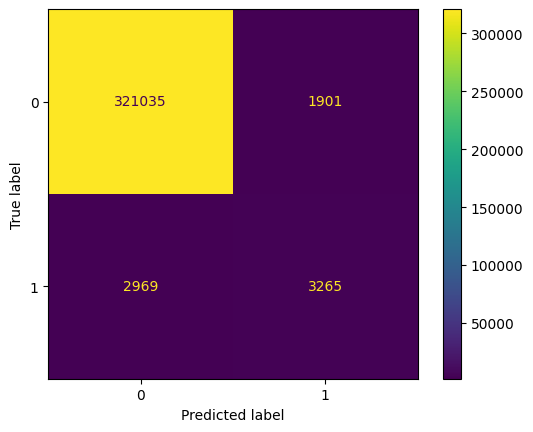

In [10]:
y_pred = tree_cv.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
CM = ConfusionMatrixDisplay(cm)
CM.plot()

In [11]:
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('accuracy  =', round(acc, 4))
print('recall\t  =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score  =', round(f1, 4))
print('AUC\t  =', round(auc(fpr, tpr),4))

accuracy  = 0.9852
recall	  = 0.5237
precision = 0.632
f1 score  = 0.5728
AUC	  = 0.7589


In [12]:
acc_list = []
rec_list = []
pre_list = []
f1_list = []
auc_list = []
folds = 10
i = 1

print('fold: ',end='')
for train, test in StratifiedKFold(n_splits=folds,random_state=1, shuffle=True).split(X, y):
    print(str(i)+' ',end='')
    i+=1
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = y.iloc[train], y.iloc[test]
    tree = DecisionTreeClassifier(min_samples_leaf= 2, min_samples_split= 3)
    tree.fit(x_train_one_fold, y_train_one_fold)
    y_pred = tree.predict(x_test_one_fold)
    
    acc_list.append(accuracy_score(y_test_one_fold, y_pred))
    rec_list.append(recall_score(y_test_one_fold, y_pred))
    pre_list.append(precision_score(y_test_one_fold, y_pred))
    f1_list.append(f1_score(y_test_one_fold, y_pred, pos_label=1))
    fpr, tpr, thresholds = roc_curve(y_test_one_fold, y_pred)
    auc_list.append(auc(fpr, tpr))
    
print("\n\naccuracy  = %.4f (%.4f)" % (stat.mean(acc_list), stat.stdev(acc_list)))
print("recall\t  = %.4f (%.4f)" % (stat.mean(rec_list), stat.stdev(rec_list)))
print("precision = %.4f (%.4f)" % (stat.mean(pre_list), stat.stdev(pre_list)))
print("f1 score  = %.4f (%.4f)" % (stat.mean(f1_list), stat.stdev(f1_list)))
print("AUC\t  = %.4f (%.4f)" % (stat.mean(auc_list), stat.stdev(auc_list)))

fold: 1 2 3 4 5 6 7 8 9 10 

accuracy  = 0.9862 (0.0003)
recall	  = 0.5501 (0.0107)
precision = 0.6610 (0.0134)
f1 score  = 0.6004 (0.0088)
AUC	  = 0.7723 (0.0053)


This model meets the success criteria of an accuracy rate of at least 80% and false positive rate of at most 5%. But because the data that was used to train this model is so imbalanced, we look to the f1 score. It is an okay score, but it does not meet the success criteria.

## 3.2 Decision Tree with Under-Samping

To manage the unbalanced data, we will use the under-sampling technique to balance the data. Under-sampling randomly takes data points from the majority class to match the number of data points in the minority class. Under-sampling can get rid of important data points, but it may also improve the f1 score. 

In [13]:
#split data by class
class0 = data[data['isFraud'] == 0]
class1 = data[data['isFraud'] == 1]
print('class 0:', class0.shape)
print('class 1:', class1.shape)

class 0: (1076568, 245)
class 1: (20663, 245)


In [14]:
#under-sample the majority class so it is balanced with the minority class
under_class0 = resample(class0, replace=False, n_samples=class1.shape[0], random_state=42)
print('new class 0:', under_class0.shape)
print('new class 1:', class1.shape)
under_data = pd.concat([under_class0, class1])

new class 0: (20663, 245)
new class 1: (20663, 245)


In [16]:
X = under_data.drop('isFraud', axis = 1)
X = pd.get_dummies(X)
y = under_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28928, 244)
(12398, 244)
(28928,)
(12398,)


In [28]:
param_grid = {
    'criterion':['entropy', 'gini'],
    'min_samples_split':[2, 3, 4],
    'min_samples_leaf':[1, 2, 3]
}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='f1', cv=5, verbose=2)
tree_cv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=2; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=2; total time=   0.9s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=2; total time=   0.9s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=3; total time=   0.8s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=3; total time=   0.9s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=3; total time=   0.9s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=3; total time=   0.9s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples_split=3; total time=   0.7s
[CV] END criterion=entropy, min_samples_leaf=1, min_samples

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1', verbose=2)

In [29]:
print(tree_cv.best_params_)

{'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 2}


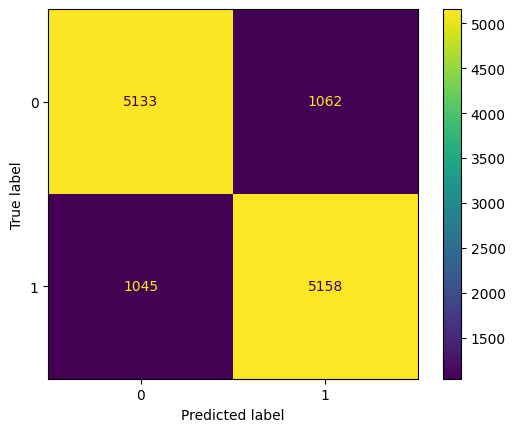

In [30]:
y_pred = tree_cv.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
CM = ConfusionMatrixDisplay(cm)
CM.plot()

In [31]:
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('accuracy  =', round(acc, 4))
print('recall\t  =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score  =', round(f1, 4))
print('AUC\t  =', round(auc(fpr, tpr),4))

accuracy  = 0.8301
recall	  = 0.8315
precision = 0.8293
f1 score  = 0.8304
AUC	  = 0.8301


In [32]:
acc_list = []
rec_list = []
pre_list = []
f1_list = []
auc_list = []
folds = 10
i = 1

print('fold: ',end='')
for train, test in StratifiedKFold(n_splits=folds,random_state=1, shuffle=True).split(X, y):
    print(str(i)+' ',end='')
    i+=1
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = y.iloc[train], y.iloc[test]
    tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3, min_samples_split=2)
    tree.fit(x_train_one_fold, y_train_one_fold)
    y_pred = tree.predict(x_test_one_fold)
    
    acc_list.append(accuracy_score(y_test_one_fold, y_pred))
    rec_list.append(recall_score(y_test_one_fold, y_pred))
    pre_list.append(precision_score(y_test_one_fold, y_pred))
    f1_list.append(f1_score(y_test_one_fold, y_pred, pos_label=1))
    fpr, tpr, thresholds = roc_curve(y_test_one_fold, y_pred)
    auc_list.append(auc(fpr, tpr))
    
print("\n\naccuracy  = %.4f (%.4f)" % (stat.mean(acc_list), stat.stdev(acc_list)))
print("recall\t  = %.4f (%.4f)" % (stat.mean(rec_list), stat.stdev(rec_list)))
print("precision = %.4f (%.4f)" % (stat.mean(pre_list), stat.stdev(pre_list)))
print("f1 score  = %.4f (%.4f)" % (stat.mean(f1_list), stat.stdev(f1_list)))
print("AUC\t  = %.4f (%.4f)" % (stat.mean(auc_list), stat.stdev(auc_list)))

fold: 1 2 3 4 5 6 7 8 9 10 

accuracy  = 0.8427 (0.0065)
recall	  = 0.8457 (0.0097)
precision = 0.8408 (0.0075)
f1 score  = 0.8432 (0.0066)
AUC	  = 0.8427 (0.0065)


By using under-sampling we reduced the accuracy from about 98% to 84%, but the accuracy still meets the success criteria. We were able to increase the f1 score from about 60% to 84%. This model's metric results are an overall improvement over the previous Decision Tree's metric results.